# CSCE 670 Spotlight: Autoencoders for Recommendation 

### Name: Venkata Prajwal Bobba

An **autoencoder** is a two layer neural network with the same size of input and output layers. Assume that we have a vector of
$\mathbb{R}^{1\times N}$ as the input, the the output of the autoencoder is:$$
                      h(x) = f(g(xV+b1)W+b2)  $$
                      **Here**: $g$ and $f$ are the activation functions of the encoding and the decoding layer respectively and $V$ and $W$ are th corresponding weights.
                      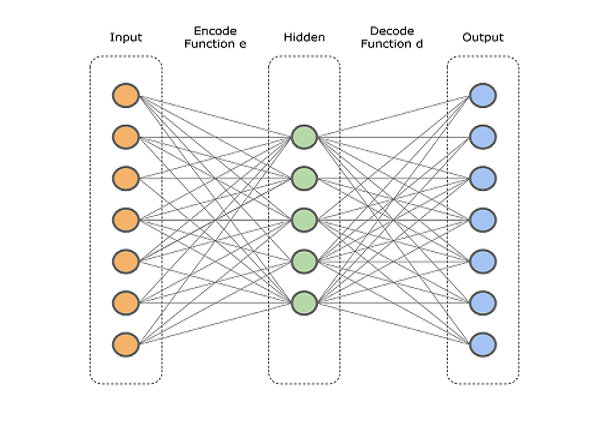
                      The output layer has the same number of neurons as the input layer for the purpose of reconstructing it’s own inputs. This makes an Autoencoder a form of unsupervised learning, which means no labelled data are necessary — only a set of input data instead of input-output pairs.<br><br>
By having lesser number of neurons in the hidden layer when compared to the input and the output layers helps autoencoders learn a hidden representation of the input vector.
The transition from the input to the hidden layer is called the encoding step and the transition from the hidden to the output layer is called the decoding step.
Autoencoder ‘s objective is to minimize reconstruction error between the input and output. This helps autoencoders to learn important features present in the data.


## Loading data 
----
Movielens dataset is provided by GroupLens lab for research purposes. The full data set contains 26,000,000 ratings and 750,000 tag applications applied to 45,000 movies by 270,000 users.<br>
For this spotlight, we use the MovieLens 1m dataset, which contains roughly 1 million ratings.<br>
In the original movie lens data set, the data is present in .dat files and they must be converted to .csv files for easy processing.

### Importing Packages

In [79]:
import os 
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Embedding, Flatten, Dropout, merge, Activation
import keras.backend as kerback
from tensorflow.python.keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
import pydot
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras import regularizers
from keras.callbacks import LearningRateScheduler

### Base-directory and Data path definitions

In [59]:
current_dir = os.getcwd()
movie_lens_dir = current_dir+"/ml-1m/"

Initially we make use of only the ratings data and so only that is considered and the corresponding csv file is generated. For the ratings prediction, only userid, movieid and rating given to the movie are required.

In [22]:
csv_ratings = "ml-1m_ratings.csv"
movie_ratings = pd.read_csv(movie_lens_dir+"ratings.dat", 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'movieid', 'rating', 'timestamp'])


Now in the movielens dataset, the userid and the movieid start from 1. For the ease of processing, this is converted to 0, as we can store it in a dataframe where the indexing starts from 0

In [23]:
print("Total number of ratings present in the Dataset: "+str(len(movie_ratings)))
movie_ratings['new_user_id'] = movie_ratings['userid'] - 1
movie_ratings['new_movie_id'] = movie_ratings['movieid'] - 1

Total number of ratings present in the Dataset: 1000209


### Saving into csv file

In [14]:
movie_ratings.to_csv(csv_ratings, 
               sep='\t', 
               header=True, 
               encoding='latin-1', 
               columns=['new_user_id', 'new_movie_id', 'rating', 'timestamp'])
print('User-movie ratings data saved to', csv_ratings)

User-movie ratings data saved to ml-1m_ratings.csv


### Reading from the csv file

In [3]:
data_frame = pd.read_csv('ml-1m_ratings.csv',sep='\t', encoding='latin-1', 
                      usecols=['new_user_id', 'new_movie_id', 'rating', 'timestamp'])
total_users = data_frame['new_user_id'].unique().max() + 1
total_movies = data_frame['new_movie_id'].unique().max() + 1
total_num_ratings = len(data_frame)
print("Total number of users: "+str(total_users))
print("Total number of movies: "+str(total_movies))
print("Total number of Ratings present: "+str(total_num_ratings)+"\n")

Total number of users: 6040
Total number of movies: 3952
Total number of Ratings present: 1000209



Now that we have the whole data in the dataframe, we need to split the data into train and test sets

### Train-test Split

In [4]:
train_data_frame,validate_data_frame = train_test_split(data_frame, test_size=0.3,random_state=4243)
print("Size of training_data: "+str(len(train_data_frame)))
print("Size of validation data: "+str(len(validate_data_frame)))

Size of training_data: 700146
Size of validation data: 300063


The minmum rating in the movielens dataset is 1, so we give a value of 0 to the ratings that are not present.

### Loading the dataframe to a numpy array 

In [21]:
def data_processing(data_frame,total_users,total_movies, add_noise=False, noise_parameter = 0.4):
    print("Loading Started")
    matrix = np.full((total_users,total_movies),0.0)
    for index,row in data_frame.iterrows():
        matrix[int(row[0])][int(row[1])] = row[2]
        if add_noise == True:
            matrix[int(row[0])][int(row[1])] = row[2]+noise_parameter*(np.random.normal())
    print("Loading Done")
    return matrix

In [11]:
train_data_matrix = data_processing(train_data_frame,total_users,total_movies)
valid_data_matrix = data_processing(validate_data_frame,total_users,total_movies)
print(train_data_matrix.shape)
print(valid_data_matrix.shape)

Loading Started
Loading Done
Loading Started
Loading Done
(6040, 3952)
(6040, 3952)


### In this part, we will build a simple autoencoder for ratings prediction using keras.

The input layer would have the dimension of the number of movies as we are trying to predict all the ratings of the
movie for a given user. And the encoding layer essentially represents the latent space of the users domain, whose size can be given as input.

In [12]:
def AutoEncoder(input_data,encoding_dim,user_info_size = 0):
    input_shape = input_data.shape
    input_layer = Input(shape = (input_shape[1],))
    encoded_layer = Dense(encoding_dim,activation = 'elu',name = "Latent_space")(input_layer)
    output_layer = Dense(input_shape[1]-user_info_size,activation='linear',name = "output_layer")(encoded_layer)
    model = Model(input_layer,output_layer)
    return model

Now that we have built our Autoencoder model, the next step is to compile this model with a loss function. But the catch here is that, there are a lot of missing ratings in the input matrix and so the traditional loss functions in keras would not work. So, we have to create a new loss function which would take into account only the ratings that are present.


### Loss Function and Evaluation Metric
For traditional backpropagation, we generally use Mean Squared Error(MSE) as a loss function, because of the ease of taking a derivative and updating all the weights.
$$mse = {(\frac{1}{n})\sum_{i=1}^{n}(y_{i} - \hat{y}_{i})^{2}}$$

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;**here**: $y_{i}$ is the true label and$\hat{y}_{i}$ is the predicted label, and $n$ is the number of training samples.<br><br>
We use a new Mean Squared Error Loss Function, which basically finds the error only for those ratings which are present in the input.
$$mse = {(\frac{1}{n})\sum_{i \epsilon D(u)}(y_{i} - \hat{y}_{i})^{2}}$$
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;**here**: $D(u)$ are all the elements whose ratings are present.<br>
We use Root Mean Squared error as the evaluation metric, and a similar process is followed to construct this metric as well.

In [13]:
def mse_loss(y_true,y_pred):
        #mask_true finds out all the ratings that are not equal to 0
        mask_true = kerback.cast(kerback.not_equal(y_true, 0), kerback.floatx())
        masked_squared_error = kerback.square(mask_true * (y_true - y_pred))
        masked_mse = kerback.sum(masked_squared_error, axis=-1) / kerback.sum(mask_true, axis=-1)
        return masked_mse

In [14]:
def rmse_metric(y_true,y_pred):
        
        mask_true = kerback.cast(kerback.not_equal(y_true, 0), kerback.floatx())
        masked_squared_error = kerback.square(mask_true * (y_true - y_pred))
        masked_mse = kerback.sum(masked_squared_error, axis=-1) / kerback.sum(mask_true, axis=-1)
        return kerback.sqrt(masked_mse)

In [15]:
def evaluate_final_rmse(y_true,y_pred):
    true_values = kerback.constant(y_true)
    pred_values = kerback.constant(y_pred)
    rmse_loss = kerback.eval(rmse_metric(true_values,pred_values))
    return np.mean(rmse_loss)

Once we have defined our loss function and evaluation metric, we can proceed to train our network

In [16]:
#RMSprop(lr=0.0005)
autorec_sys = AutoEncoder(train_data_matrix,256)
autorec_sys.compile(optimizer = RMSprop(lr=0.0005), loss=mse_loss, metrics=[rmse_metric])
autorec_sys.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3952)]            0         
_________________________________________________________________
Latent_space (Dense)         (None, 256)               1011968   
_________________________________________________________________
output_layer (Dense)         (None, 3952)              1015664   
Total params: 2,027,632
Trainable params: 2,027,632
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = autorec_sys.fit(train_data_matrix,train_data_matrix,batch_size = 64,epochs = 50,verbose = 1,validation_data = [valid_data_matrix,valid_data_matrix])

Train on 6040 samples, validate on 6040 samples
Epoch 1/50
6040/6040 [==============================] - 4s 661us/sample - loss: 4.0054 - rmse_metric: 1.8217 - val_loss: 3.1202 - val_rmse_metric: 1.6708
Epoch 2/50
6040/6040 [==============================] - 4s 640us/sample - loss: 1.2253 - rmse_metric: 1.0704 - val_loss: 1.6859 - val_rmse_metric: 1.2342
Epoch 3/50
6040/6040 [==============================] - 4s 631us/sample - loss: 0.9022 - rmse_metric: 0.9282 - val_loss: 1.3477 - val_rmse_metric: 1.1107
Epoch 4/50
6040/6040 [==============================] - 4s 656us/sample - loss: 0.7712 - rmse_metric: 0.8593 - val_loss: 1.1949 - val_rmse_metric: 1.0486
Epoch 5/50
6040/6040 [==============================] - 4s 625us/sample - loss: 0.6774 - rmse_metric: 0.8056 - val_loss: 1.1359 - val_rmse_metric: 1.0246
Epoch 6/50
6040/6040 [==============================] - 4s 679us/sample - loss: 0.5962 - rmse_metric: 0.7556 - val_loss: 1.1196 - val_rmse_metric: 1.0178
Epoch 7/50
6040/6040 [======

Now lets calculate the masked rmse from the predicted ratings and the original ratings from the validation set

In [18]:
predicted_ratings = autorec_sys.predict(valid_data_matrix)
print("RMSE loss as measured on the validation set: "+str(evaluate_final_rmse(valid_data_matrix,predicted_ratings)))

RMSE loss as measured on the validation set: 1.0745349


### Error visualization

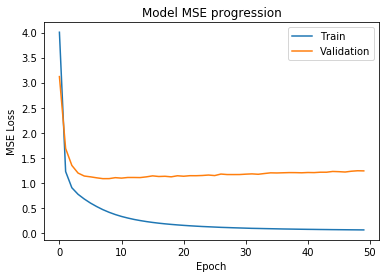

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model MSE progression')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

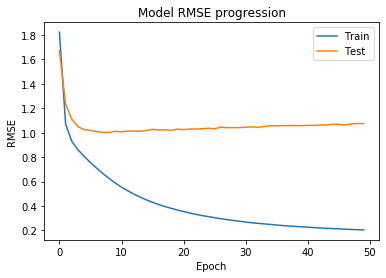

In [20]:
plt.plot(history.history['rmse_metric'])
plt.plot(history.history['val_rmse_metric'])
plt.title('Model RMSE progression')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

### Adding Noise parameter

Adding noise to the input would learn the paramters better as it could learn hidden parameters.

In [22]:
noise_train_data_matrix = data_processing(train_data_frame,total_users,total_movies,True)
noise_valid_data_matrix = data_processing(validate_data_frame,total_users,total_movies,True)
print(noise_train_data_matrix.shape)
print(noise_valid_data_matrix.shape)

Loading Started
Loading Done
Loading Started
Loading Done
(6040, 3952)
(6040, 3952)


In [25]:
autorec_sys_noise = AutoEncoder(train_data_matrix,512)
autorec_sys_noise.compile(optimizer = RMSprop(lr=0.0005), loss=mse_loss, metrics=[rmse_metric])
autorec_sys_noise.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3952)]            0         
_________________________________________________________________
Latent_space (Dense)         (None, 512)               2023936   
_________________________________________________________________
output_layer (Dense)         (None, 3952)              2027376   
Total params: 4,051,312
Trainable params: 4,051,312
Non-trainable params: 0
_________________________________________________________________


In [26]:
learning_rate = 0.0005
def scheduler(epoch):
    if epoch%20 == 0:
        kerback.set_value(autorec_sys_noise.optimizer.lr, learning_rate-0.0001)
    return kerback.get_value(autorec_sys_noise.optimizer.lr)
change_lr = LearningRateScheduler(scheduler)
history_1 = autorec_sys_noise.fit(noise_train_data_matrix,train_data_matrix,batch_size = 64,epochs = 50,verbose = 1,validation_data = [noise_valid_data_matrix,valid_data_matrix])

Train on 6040 samples, validate on 6040 samples
Epoch 1/50
6040/6040 [==============================] - 7s 1ms/sample - loss: 3.1467 - rmse_metric: 1.6002 - val_loss: 2.1435 - val_rmse_metric: 1.3679
Epoch 2/50
6040/6040 [==============================] - 6s 1ms/sample - loss: 0.9597 - rmse_metric: 0.9549 - val_loss: 1.4446 - val_rmse_metric: 1.1383
Epoch 3/50
6040/6040 [==============================] - 6s 1ms/sample - loss: 0.7215 - rmse_metric: 0.8310 - val_loss: 1.2604 - val_rmse_metric: 1.0670
Epoch 4/50
6040/6040 [==============================] - 6s 1ms/sample - loss: 0.5647 - rmse_metric: 0.7349 - val_loss: 1.1788 - val_rmse_metric: 1.0354
Epoch 5/50
6040/6040 [==============================] - 6s 1ms/sample - loss: 0.4428 - rmse_metric: 0.6486 - val_loss: 1.1443 - val_rmse_metric: 1.0227
Epoch 6/50
6040/6040 [==============================] - 7s 1ms/sample - loss: 0.3485 - rmse_metric: 0.5721 - val_loss: 1.1078 - val_rmse_metric: 1.0071
Epoch 7/50
6040/6040 [==================

In [27]:
predicted_ratings = autorec_sys_noise.predict(noise_valid_data_matrix)
print("RMSE loss as measured on the validation set: "+str(evaluate_final_rmse(noise_valid_data_matrix,predicted_ratings)))

RMSE loss as measured on the validation set: 1.0442927


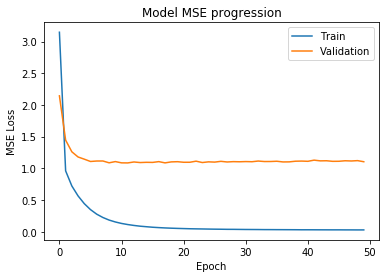

In [28]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model MSE progression')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Deep Autoencoder recommendation System
In a traditional autoencoder, we just have a single hidden layer apart from the input and the output layers. So,
in this, we construct a Deep Autoencoder instead of the traitional one and check the performance on that.

In [76]:
def Deep_Auto_Encoder(input_data,encoding_dim):
    #You can add any number of layers in between by following this procedure
    #in this case the hidden layers have [1024,512,256,512,1204] nodes
    input_shape = input_data.shape
    input_layer = Input(shape = (input_shape[1],))
    encoded_layer_1 = Dense(1024,activation = 'linear',name = "Encoded_layer_1")(input_layer)
    latent_space_layer = Dense(encoding_dim,activation = 'relu',name = "Latent_space")(encoded_layer_1)
    decoded_layer_2 = Dense(1024,activation = 'linear',name = "Decoded_layer_2")(latent_space_layer)
    output_layer = Dense(input_shape[1],activation='selu',name = "output_layer")(decoded_layer_2)
    model = Model(input_layer,output_layer)
    return model

In [78]:
deep_autorec_sys = Deep_Auto_Encoder(train_data_matrix,512)
deep_autorec_sys.compile(optimizer = RMSprop(lr=0.0005), loss=mse_loss, metrics=[rmse_metric])
deep_autorec_sys.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 3952)]            0         
_________________________________________________________________
Encoded_layer_1 (Dense)      (None, 1024)              4047872   
_________________________________________________________________
Latent_space (Dense)         (None, 512)               524800    
_________________________________________________________________
Decoded_layer_2 (Dense)      (None, 1024)              525312    
_________________________________________________________________
output_layer (Dense)         (None, 3952)              4050800   
Total params: 9,148,784
Trainable params: 9,148,784
Non-trainable params: 0
_________________________________________________________________


In [55]:
# learning_rate = 0.0005
# def scheduler(epoch,learning_rate):
#     if epoch%10 == 0:
#         learning_rate = learning_rate/2
#         kerback.set_value(deep_autorec_sys.optimizer.lr, learning_rate-0.0001)
#     return kerback.get_value(deep_autorec_sys.optimizer.lr)
# change_lr = LearningRateScheduler(scheduler,learning_rate)

history = deep_autorec_sys.fit(train_data_matrix,train_data_matrix,batch_size = 256,epochs = 100,verbose = 1,validation_data = [valid_data_matrix,valid_data_matrix])

Train on 6040 samples, validate on 6040 samples
Epoch 1/100
6040/6040 [==============================] - 10s 2ms/sample - loss: 13.4818 - rmse_metric: 2.9992 - val_loss: 8.3438 - val_rmse_metric: 2.0496
Epoch 2/100
6040/6040 [==============================] - 7s 1ms/sample - loss: 5.8835 - rmse_metric: 1.4089 - val_loss: 5.8443 - val_rmse_metric: 1.4087
Epoch 3/100
6040/6040 [==============================] - 7s 1ms/sample - loss: 4.7353 - rmse_metric: 1.0606 - val_loss: 5.0514 - val_rmse_metric: 1.1915
Epoch 4/100
6040/6040 [==============================] - 7s 1ms/sample - loss: 4.4392 - rmse_metric: 0.9925 - val_loss: 4.7553 - val_rmse_metric: 1.1369
Epoch 5/100
6040/6040 [==============================] - 7s 1ms/sample - loss: 4.2422 - rmse_metric: 0.9662 - val_loss: 4.5463 - val_rmse_metric: 1.1108
Epoch 6/100
6040/6040 [==============================] - 7s 1ms/sample - loss: 4.0721 - rmse_metric: 0.9488 - val_loss: 4.3684 - val_rmse_metric: 1.0933
Epoch 7/100
6040/6040 [=========

Epoch 54/100
6040/6040 [==============================] - 8s 1ms/sample - loss: 1.2029 - rmse_metric: 0.5732 - val_loss: 1.9405 - val_rmse_metric: 1.0047
Epoch 55/100
6040/6040 [==============================] - 8s 1ms/sample - loss: 1.1831 - rmse_metric: 0.5696 - val_loss: 1.9076 - val_rmse_metric: 0.9970
Epoch 56/100
6040/6040 [==============================] - 8s 1ms/sample - loss: 1.1635 - rmse_metric: 0.5657 - val_loss: 1.8876 - val_rmse_metric: 0.9949
Epoch 57/100
6040/6040 [==============================] - 8s 1ms/sample - loss: 1.1448 - rmse_metric: 0.5621 - val_loss: 1.8747 - val_rmse_metric: 0.9957
Epoch 58/100
6040/6040 [==============================] - 9s 1ms/sample - loss: 1.1269 - rmse_metric: 0.5586 - val_loss: 1.8573 - val_rmse_metric: 0.9941
Epoch 59/100
6040/6040 [==============================] - 9s 1ms/sample - loss: 1.1095 - rmse_metric: 0.5555 - val_loss: 1.8378 - val_rmse_metric: 0.9920
Epoch 60/100
6040/6040 [==============================] - 8s 1ms/sample - lo

In [56]:
predicted_ratings = deep_autorec_sys.predict(valid_data_matrix)
print("RMSE loss as measured on the validation set: "+str(evaluate_final_rmse(valid_data_matrix,predicted_ratings)))

RMSE loss as measured on the validation set: 0.95202297


### Collaborative Denoising Autoencoder(CDAE)

It is found out that modelling the user realted features as a one hot encoding in the input of the autoencoder increases the performance of the system.

Similar to the standard Denoising Auto-Encoder, CDAE is also represented as a one-hidden-layer neural network. The key difference is that the input also encodes a latent vector for the user, which allows CDAE to be a much better recommender.
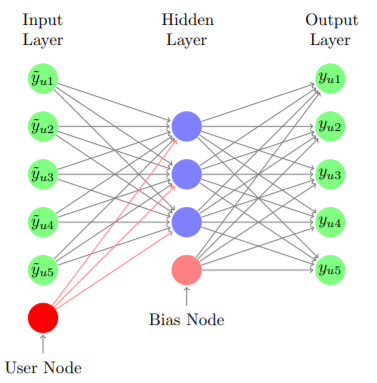
<br>

In the input layer, there are in total $I$ + 1 nodes, where each of
the first $I$ nodes corresponds to an item, and the last node is a userspecific node (the red node in the figure), which means the node and
its associated weights are unique for each user $u ∈ U$ in the data.
Here  $y_{u} = \{y_{u1}, y_{u2}, ..., y_{uI} \}$ is the
I-dimensional feedback vector of user $u$ on all the item in $I$. 


### Forming the one hot encoding vector from the Users information provided

Processing information from .dat file provided and saving into csv file.

In [57]:
users_info_file = "users_info.csv"
# each of the age is represented by a number
ages = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
#each of the occupation is represented by a number, so that this can be used for contructing the one hot encoding
occupations = { 0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                4: "college/grad student", 5: "customer service", 6: "doctor/health care",
                7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
                12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
                17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer" }


In [61]:
users_info = pd.read_csv(movie_lens_dir+"users.dat", 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'gender', 'age', 'occupation', 'zipcode'])
max_userid = users_info['userid'].drop_duplicates().max()
#Converting that particular column to integer representation
users_info['occ_desc'] = users_info['occupation'].apply(lambda x: occupations[x])

users_info['age_desc'] = users_info['age'].apply(lambda x: ages[x])

Saving into csv file

In [63]:
#making the user id start from 1
users_info['user_emb_id'] = users_info['userid'] - 1
users_info.to_csv(users_info_file, 
             sep='\t', 
             header=True, 
             encoding='latin-1',
             columns=['user_emb_id', 'gender', 'age', 'occupation', 'zipcode', 'age_desc', 'occ_desc'])
print('Saved to', users_info_file)

Saved to users_info.csv


Loading data from csv file and constructing the one hot vector

In [82]:
user_df = pd.read_csv('users_info.csv',sep='\t', encoding='latin-1', 
                      usecols=['user_emb_id', 'gender', 'age', 'occupation'])
user_df['age'] = preprocessing.LabelEncoder().fit(user_df['age']).transform(user_df['age'])
user_df['gender'] = preprocessing.LabelEncoder().fit(user_df['gender']).transform(user_df['gender'])
onehot_df = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False).fit(user_df[['gender', 'age', 'occupation']]).transform(user_df[['gender', 'age', 'occupation']])


(6040, 1)


Once we have the features, we take the mean of then and add it as a user node.

In [87]:
b = (np.mean(onehot_df,axis=1)).reshape(6040,1)
print(b.shape)

(6040, 1)


In [83]:
train_data_matrix_userinfo = np.concatenate((train_data_matrix, b), axis=1)
valid_data_matrix_userinfo = np.concatenate((valid_data_matrix,b),axis=1)
print(train_data_matrix.shape)
print(train_data_matrix_userinfo.shape)
print(valid_data_matrix_userinfo.shape)

(6040, 3952)
(6040, 3953)
(6040, 3953)


### Training the autoencoder with this data

In [84]:
autorec_sys_userinfo = AutoEncoder(train_data_matrix_userinfo,1000,1)
autorec_sys_userinfo.compile(optimizer = RMSprop(lr=0.001), loss=mse_loss, metrics=[rmse_metric])
autorec_sys_userinfo.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 3953)]            0         
_________________________________________________________________
Latent_space (Dense)         (None, 1000)              3954000   
_________________________________________________________________
output_layer (Dense)         (None, 3952)              3955952   
Total params: 7,909,952
Trainable params: 7,909,952
Non-trainable params: 0
_________________________________________________________________


In [85]:
history = autorec_sys_userinfo.fit(train_data_matrix_userinfo,train_data_matrix,batch_size = 64,epochs = 50,verbose = 1,validation_data = [valid_data_matrix_userinfo,valid_data_matrix])

Train on 6040 samples, validate on 6040 samples
Epoch 1/50
6040/6040 [==============================] - 15s 3ms/sample - loss: 1.9593 - rmse_metric: 1.2666 - val_loss: 1.4696 - val_rmse_metric: 1.1571
Epoch 2/50
6040/6040 [==============================] - 11s 2ms/sample - loss: 0.6521 - rmse_metric: 0.7867 - val_loss: 1.2133 - val_rmse_metric: 1.0515
Epoch 3/50
6040/6040 [==============================] - 12s 2ms/sample - loss: 0.3639 - rmse_metric: 0.5788 - val_loss: 1.1313 - val_rmse_metric: 1.0160
Epoch 4/50
6040/6040 [==============================] - 12s 2ms/sample - loss: 0.2633 - rmse_metric: 0.4899 - val_loss: 1.0847 - val_rmse_metric: 0.9943
Epoch 5/50
6040/6040 [==============================] - 12s 2ms/sample - loss: 0.2280 - rmse_metric: 0.4561 - val_loss: 1.0935 - val_rmse_metric: 0.9984
Epoch 6/50
6040/6040 [==============================] - 12s 2ms/sample - loss: 0.2066 - rmse_metric: 0.4347 - val_loss: 1.0961 - val_rmse_metric: 0.9995
Epoch 7/50
6040/6040 [============

In [86]:
predicted_ratings = autorec_sys_userinfo.predict(valid_data_matrix_userinfo)
print("RMSE loss as measured on the validation set: "+str(evaluate_final_rmse(valid_data_matrix,predicted_ratings)))

RMSE loss as measured on the validation set: 0.9375417


## Conclusion
Autoencoders have proven to be an effective tool for rating recommendation. As shown in this spotlight, addition of noise to the input improves the RMSE score, and a Deep Autoencoder performs better than the standard autoencoder. It was also shown that the highest performance gain is achieved by addition of user related features to the input.
I think we can see significant performance gains after hyperparameter tuning of the networks.

## Collaboration Declarations


* Masked MSE implementation is done referring to: https://github.com/keras-team/keras/issues/7065
* Some of the intuition on implementing the last part of the spotlight was developed referring to : github.com/RaptorMai/ repository on recommendation